#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Dummy-(Constant)" data-toc-modified-id="Dummy-(Constant)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dummy (Constant)</a></span></li><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

Импортируем библиотеки:

In [1]:
import datetime

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    TimeSeriesSplit,
)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from joblib import parallel_backend

Загрузим данные:

In [2]:
df = pd.read_csv('~/DS/Datasets/taxi.csv')

Изучим первые десять строк таблицы:

In [3]:
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Изучим информацию о таблице:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Переведём колонку с датой в формат `datetime`:

In [5]:
df['datetime'] = df['datetime'].astype('datetime64')

Проверим:

In [6]:
df['datetime']

0       2018-03-01 00:00:00
1       2018-03-01 00:10:00
2       2018-03-01 00:20:00
3       2018-03-01 00:30:00
4       2018-03-01 00:40:00
                ...        
26491   2018-08-31 23:10:00
26492   2018-08-31 23:20:00
26493   2018-08-31 23:30:00
26494   2018-08-31 23:40:00
26495   2018-08-31 23:50:00
Name: datetime, Length: 26496, dtype: datetime64[ns]

Заменим индексы на временные отметки:

In [7]:
df.set_index('datetime', inplace=True)

Проверим проделанную работу:

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выполним ресемплирование по одному часу:

In [9]:
df = df.resample('1H').sum()

Проверим, что у нас получилось:

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


---

Начнём добавлять признаки для наших моделей, добавим годы, месяцы, дни, дни недели и часы:

In [11]:
df_expanded = df.copy(deep=True)
df_expanded['year'] = df.index.year
df_expanded['month'] = df.index.month
df_expanded['day'] = df.index.day
df_expanded['day_of_week'] = df.index.day_of_week
df_expanded['hour'] = df.index.hour

Посмотрим, что у нас получилось:

In [12]:
df_expanded.head()

,num_orders,year,month,day,day_of_week,hour
datetime,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0
2018-03-01 01:00:00,85,2018,3,1,3,1
2018-03-01 02:00:00,71,2018,3,1,3,2
2018-03-01 03:00:00,66,2018,3,1,3,3
2018-03-01 04:00:00,43,2018,3,1,3,4


Разделим признаки и целевой признак:

In [13]:
features = df_expanded.drop('num_orders', axis=1)
target = df_expanded['num_orders']

Напишем функцию для создания признаков и для дальнейшего подбора параметров:

In [14]:
def make_features(features, target, count_lag, rolling):
    """
    Функция принимает на вход признаки и целевой признак, а также
    параметры количества отстающих признаков и размер скользящего окна.
    Создаёт новые признаки и возвращает новую таблицу с признаками.
    """
    features = features.copy(deep=True)
    for index in range(count_lag):
        features[f'lag_{index}'] = target.shift(index + 1, fill_value=0)
    features['rolling'] = target.shift().rolling(rolling).mean().fillna(0)
    return features

Напишем функцию для вычисления RMSE:

In [15]:
def rmse(*args, **kwargs):
    return mean_squared_error(*args, **kwargs, squared=False)

Сделаем из неё scorer:

In [16]:
scorer = make_scorer(rmse, greater_is_better=False)

**Вывод**

Мы заменили стандартные индексы временными метками, а также выполнили ресемплирование, объёдинив десятиминутные отрезки в один час.

## Анализ

Изучим целевой признак подробнее:

In [17]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Построим гистограмму:

<AxesSubplot:>

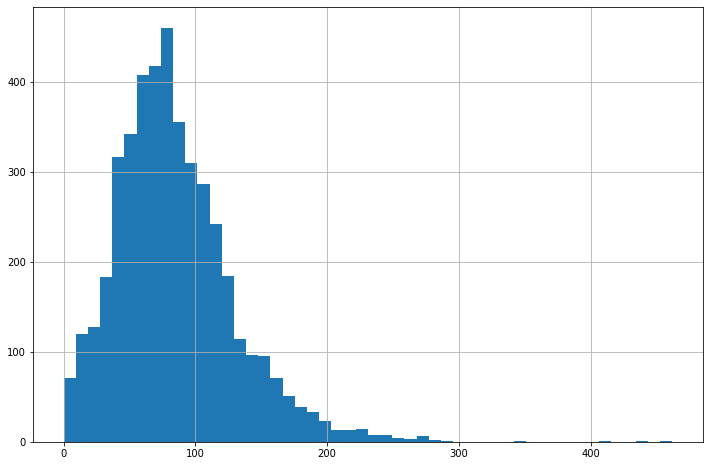

In [18]:
df['num_orders'].hist(figsize=(12, 8), bins=50, grid=True, legend=False)

Изучим подробнее редкие случаи:

<AxesSubplot:>

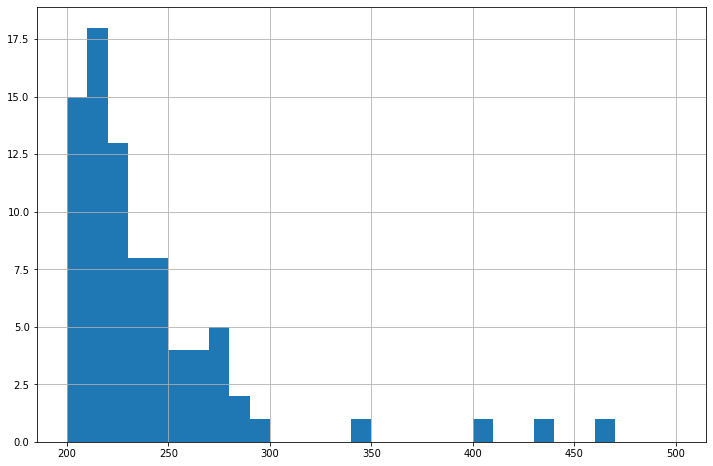

In [19]:
df['num_orders'].hist(figsize=(12, 8), bins=30, grid=True, legend=False, range=(200, 500))

Выполним сезонную декомпозицию:

In [20]:
decomposed = seasonal_decompose(df)

Построим график сезонности:

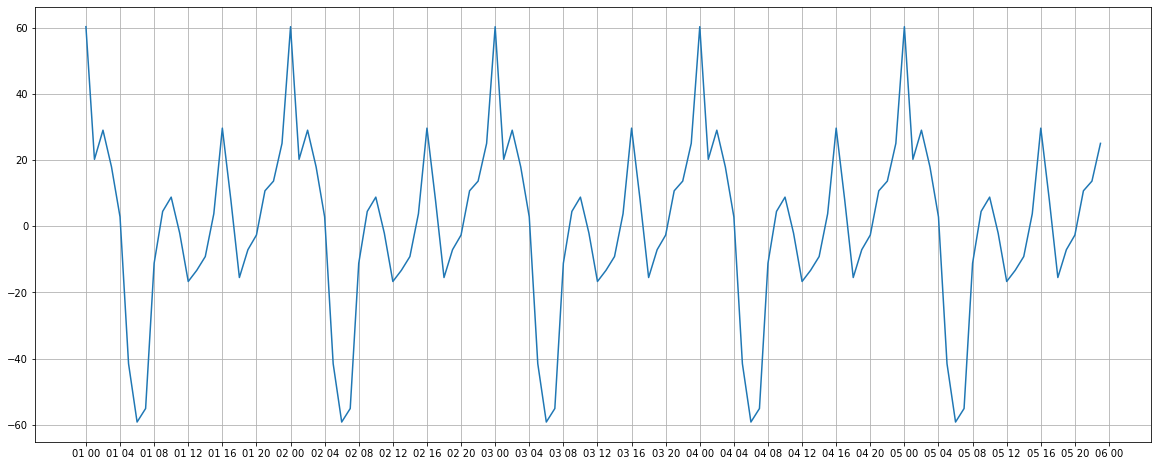

In [21]:
seasonal = decomposed.seasonal['2018-05-01':'2018-05-05']
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(seasonal.index, seasonal)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
plt.xticks(pd.date_range(start='2018-05-01', end='2018-05-06', freq='4H'))
plt.grid()

Построим график тренда:

<AxesSubplot:xlabel='datetime'>

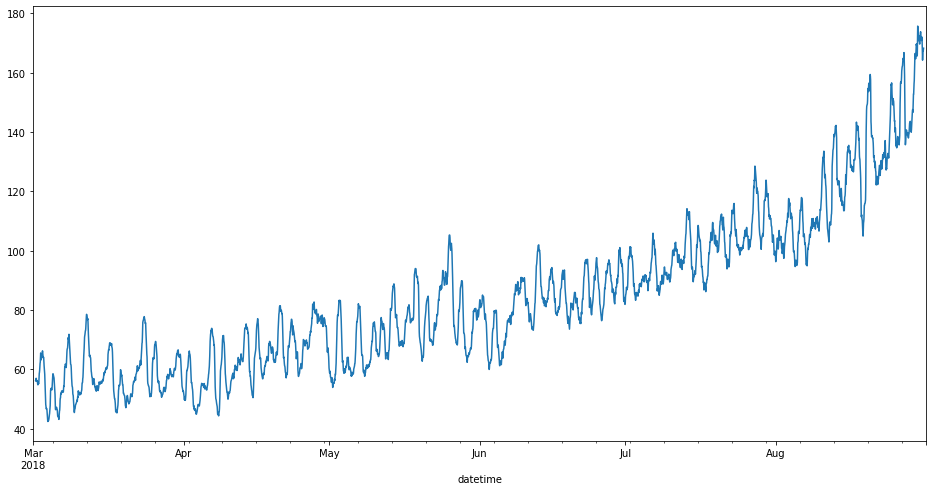

In [22]:
decomposed.trend.plot(figsize=(16, 8))

**Вывод**

Распределение выглядит нормальным, после 300 несколько раз встречаются аномальные значения. График сезонности стационарный, на нём чётко видно, что количество заказов зависит от времени суток. Есть несколько пиков: ~10 часов, 16 часов, полночь и ~2 часа ночи. Также есть сильный провал в ~6 утра. График тренда нестационарный, мы видим, как чётко растёт количество заказов от времени года: весной заказов мало, а летом и под самый конец лета график доходит до максимума.

## Обучение

Попробуем обучить пять моделей:

- Константную
- Линейную регрессию
- Дерево решений
- Случайный лес
- CatBoost

Для проверки адекватности наших моделей мы будем орентироваться на константную модель. Выполним на ней предсказания, а также посчитаем RMSE.

### Dummy (Constant)

Разделим выборки на две части тренировочную для кросс-валидации и тестовую:

In [23]:
features_train_cv, features_test, target_train_cv, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1,
)

Создадим модель:

In [24]:
model = DummyRegressor(strategy='constant', constant=target_train_cv.median())

Выполним кросс-валидацию:

In [25]:
scores = cross_val_score(model, features_train_cv, target_train_cv, cv=3, scoring=scorer)
scores

array([-34.17106798, -34.20371821, -46.69942294])

Изучим среднее:

In [26]:
-scores.mean()

38.358069709894494

Обучим модель:

In [27]:
model.fit(features_train_cv, target_train_cv)

DummyRegressor(constant=array(75.), strategy='constant')

Выполним предсказание на тестовой выборке:

In [28]:
predicted_test = model.predict(features_test)

Посчитаем RMSE:

In [29]:
rmse(target_test, predicted_test)

87.15277582981295

**Вывод**

Теперь у нас есть значения RMSE от которых мы можем отталкиваться.

### Линейная модель

Чтобы определить оптимальные признаки для той или иной модели, напишем функцию, которая на вход будет принимать класс модели, а в течении выполнения будет печатать лучшие параметры для признаков, а также возвращать лучший RMSE. Для ускорения подбора используем функцию для асинхронного выполнения вычислений. Режим выполнения выберем в виде потоков, а количество потоков будем выбирать в дальнейшем:

In [30]:
def print_best_lag_roll(class_model, max_lag=10, max_rolling=10,
                        threads=1, *args, **kwargs):
    """
    Функция на вход принимает модель, у которой есть методы fit и predict,
    также функция принимает на вход необязательные параметры max_lag и max_rolling
    для подбора этих параметров, по умолчанию они оба равны десяти. Функция может
    выполняться в асинхронном режиме, для этого можно передать параметр threads и
    указать нужное количество потоков. Если для модели нужно передать какие-либо аргументы,
    укажите их дополнительно в этой функции. В течении выполнения функция будет распечатывать
    лучшие результаты с подобранными параметрами, а в конце вернёт массив лучших RMSE.
    """
    with parallel_backend('threading', threads):
        time_split = TimeSeriesSplit(3)
        best_score = float('inf')
        best_scores = []
        for lag in range(1, max_lag):
            for rolling in range(2, max_rolling):
                model = class_model(*args, **kwargs)
                features_expanded = make_features(features, target, lag, rolling)
                features_train, _, target_train, _ = train_test_split(
                    features_expanded, target, shuffle=False, test_size=0.1,
                )
                scores = cross_val_score(
                    model, features_train, target_train, cv=time_split, scoring=scorer,
                )
                score = scores.mean() * -1
                if score >= best_score:
                    continue
                best_score = score
                best_scores = scores
                print(f'New best score: {score}; Lag: {lag}; Rolling: {rolling}')
    return best_scores

Теперь выполним несколько раз обучение и предсказание с подбором параметров для признаков:

In [31]:
%%time

print_best_lag_roll(LinearRegression)

New best score: 32.53966756349113; Lag: 1; Rolling: 2
New best score: 32.53956429646944; Lag: 1; Rolling: 4
New best score: 32.5293180621117; Lag: 1; Rolling: 5
New best score: 32.52108787111496; Lag: 1; Rolling: 6
New best score: 32.45192521209631; Lag: 2; Rolling: 3
New best score: 32.41410183766743; Lag: 2; Rolling: 4
CPU times: user 4.86 s, sys: 15.2 s, total: 20.1 s
Wall time: 996 ms


array([-29.37388885, -30.46966108, -37.39875559])

**Вывод**

Линейная модель не ушла слишком далеко от константной, давайте попробуем воспользоваться другими моделями.

### Дерево решений

Теперь попробуем модель дерева, для этой модели будем подбирать максимальную глубину. Для ускорения подбора используем наш аргумент для асинхронного выполнения вычислений. Количество потоков укажем по количеству физических ядер:

In [32]:
%%time

best_scores = []
best_score = float('inf')
for depth in range(1, 16):
    print(f'Depth #{depth}')
    scores = print_best_lag_roll(
        DecisionTreeRegressor, threads=12, max_depth=depth, random_state=1,
    )
    score = scores.mean() * -1
    if score >= best_score:
        continue
    best_score = score
    best_scores = scores
    print(f'✨ New best score: {score}; Max depth: {depth} ✨')
best_scores

Depth #1
New best score: 38.0334414888392; Lag: 1; Rolling: 2
✨ New best score: 38.0334414888392; Max depth: 1 ✨
Depth #2
New best score: 36.069891098456075; Lag: 1; Rolling: 2
✨ New best score: 36.069891098456075; Max depth: 2 ✨
Depth #3
New best score: 35.06636286689906; Lag: 1; Rolling: 2
New best score: 34.97041382511028; Lag: 1; Rolling: 3
New best score: 34.7340806562385; Lag: 1; Rolling: 6
New best score: 34.60051666500748; Lag: 1; Rolling: 7
✨ New best score: 34.60051666500748; Max depth: 3 ✨
Depth #4
New best score: 34.247437594240246; Lag: 1; Rolling: 2
New best score: 33.5177380451476; Lag: 1; Rolling: 3
New best score: 33.5117418800757; Lag: 2; Rolling: 3
✨ New best score: 33.5117418800757; Max depth: 4 ✨
Depth #5
New best score: 33.401895063184895; Lag: 1; Rolling: 2
New best score: 32.583876739494855; Lag: 1; Rolling: 3
New best score: 32.55563324320346; Lag: 1; Rolling: 4
✨ New best score: 32.55563324320346; Max depth: 5 ✨
Depth #6
New best score: 32.42165183626432; Lag:

array([-28.58603382, -28.87320747, -33.43219292])

**Вывод**

Мы успешно подобрали лучшие параметры для дерева решений: максимальная глубина — 8, lag — 4, rolling — 9, но у нас всё равно не получилось далеко уйти, как от константной модели, так и от линейной.

### Случайный лес

Так как модель случайного леса обучается довольно долго, сначала подберём оптимальные настройки признаков для нашей модели с не очень большим количеством деревьев:

In [33]:
%%time

print_best_lag_roll(RandomForestRegressor, max_lag=20, max_rolling=20, threads=12, n_estimators=30, max_depth=8, random_state=1)

New best score: 29.151519331438113; Lag: 1; Rolling: 2
New best score: 28.820819493064306; Lag: 1; Rolling: 3
New best score: 28.742972955486724; Lag: 1; Rolling: 5
New best score: 28.64410366136831; Lag: 1; Rolling: 6
New best score: 28.231215263767865; Lag: 1; Rolling: 7
New best score: 28.16481074575103; Lag: 1; Rolling: 8
New best score: 28.084815080608212; Lag: 1; Rolling: 13
New best score: 28.010358804100957; Lag: 1; Rolling: 14
New best score: 28.005490248241752; Lag: 12; Rolling: 7
New best score: 27.921208999870213; Lag: 12; Rolling: 12
New best score: 27.90901995185152; Lag: 13; Rolling: 12
New best score: 27.795336051295948; Lag: 17; Rolling: 8
New best score: 27.7676333401119; Lag: 17; Rolling: 12
CPU times: user 2min 49s, sys: 989 ms, total: 2min 50s
Wall time: 1min 30s


array([-25.3729381 , -25.17450435, -32.75545757])

Как мы выяснили самые низкие значения у нас встречаются, когда мы делим создаём признаки с параметров `lag` равным 17 и с параметром `rolling` равным 12, поэтому далее не будем подбирать эти параметры. Для подбора параметров модели случайного леса будем использовать `GridSearchCV`. Для начала создадим признаки:

In [34]:
features_expanded = make_features(features, target, 17, 12)

Разделим выборки на две части тренировочную для кросс-валидации и тестовую:

In [35]:
features_train_cv, features_test, target_train_cv, target_test = train_test_split(
    features_expanded, target, shuffle=False, test_size=0.1,
)

Создадим экземпляр TimeSeriesSplit для кросс-валидации:

In [36]:
time_split = TimeSeriesSplit(3)

Создадим `GridSearchCV`, укажем параметр `n_jobs`, чтобы подбор происходил параллельно:

In [37]:
grid_search = GridSearchCV(RandomForestRegressor(), param_grid={
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [3, 5, 10, 15, 20],
    'random_state': [1],
}, scoring=scorer, cv=time_split, verbose=1, n_jobs=12)

Подберём параметры:

In [38]:
%%time

grid_search.fit(features_train_cv, target_train_cv)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
CPU times: user 24.8 s, sys: 123 ms, total: 25 s
Wall time: 54.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=12,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'n_estimators': [10, 50, 100, 500, 1000],
                         'random_state': [1]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=1)

Изучим лучшие параметры:

In [39]:
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 1000, 'random_state': 1}

Посмотрим на лучший счёт RMSE:

In [40]:
-grid_search.best_score_

26.694477228633584

**Вывод**

Нам удалось добиться чуть лучше результата, чем у дерева решений, хоть и пришлось немного подождать!

### CatBoost

Создадим модель, обучать будем на GPU, чтобы ускорить наше обучение:

In [41]:
model = CatBoostRegressor(iterations=1000, task_type='GPU', verbose=500, random_state=1)

Выполним кросс-валидацию:

In [42]:
%%time

scores = cross_val_score(model, features_train_cv, target_train_cv, scoring=scorer, cv=time_split)
scores

Learning rate set to 0.040367
0:	learn: 28.7674526	total: 8.42ms	remaining: 8.41s
500:	learn: 11.2159906	total: 3.2s	remaining: 3.19s
999:	learn: 9.6924341	total: 6.2s	remaining: 0us
Learning rate set to 0.044198
0:	learn: 31.2546938	total: 6.92ms	remaining: 6.91s
500:	learn: 13.5633423	total: 3.08s	remaining: 3.07s
999:	learn: 11.8555835	total: 6.08s	remaining: 0us
Learning rate set to 0.046607
0:	learn: 33.2054915	total: 6.94ms	remaining: 6.93s
500:	learn: 15.3621093	total: 3.19s	remaining: 3.18s
999:	learn: 13.7025744	total: 6.24s	remaining: 0us
CPU times: user 21.3 s, sys: 2.92 s, total: 24.2 s
Wall time: 19.7 s


array([-25.07525383, -24.59517955, -29.57070034])

Для сравнения с остальными моделями суммируем результаты и уберём минус:

In [43]:
-scores.mean()

26.413711242453957

**Вывод**

Хоть мы и не подбирали параметров для CatBoost, но всё же он показывает в данной ситуации результаты лучше чем у всех предыдущих моделей, пускай и не сильно, но всё же мы не подбирали параметры.

## Тестирование

Так как CatBoost у нас показывает лучшие результаты, попробуем выполнить предсказание на тестовой выборке, для этого обучим её:

In [44]:
model.fit(features_train_cv, target_train_cv)

Learning rate set to 0.048396
0:	learn: 37.7361479	total: 6.91ms	remaining: 6.91s
500:	learn: 17.1451532	total: 3.24s	remaining: 3.22s
999:	learn: 15.2695820	total: 6.49s	remaining: 0us


Выполним предсказание:

In [45]:
predicted_test = model.predict(features_test)

Посчитаем RMSE:

In [46]:
rmse(target_test, predicted_test)

41.47132399278716

Сравним предсказания и оригинальные значения, для этого построим график:

Text(0.5, 1.0, 'Comparison Target / Predicted')

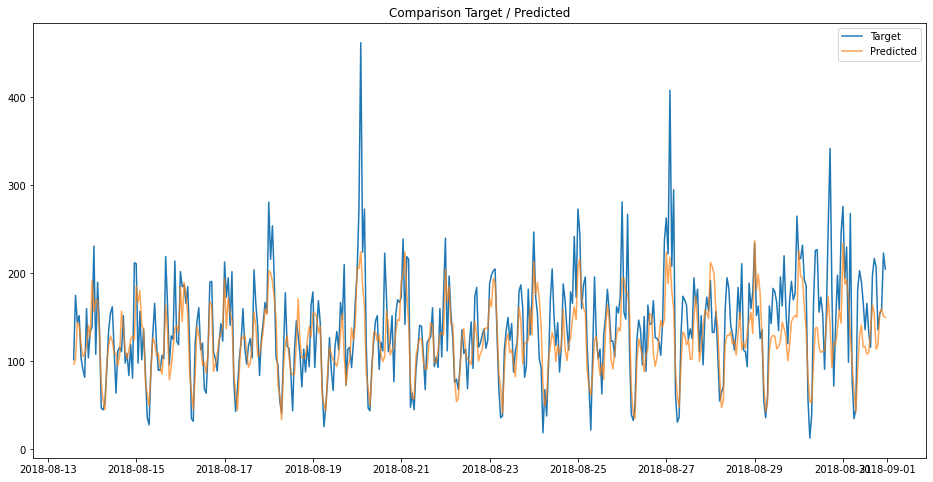

In [47]:
figure, ax = plt.subplots(figsize=(16, 8))
ax.plot(target_test.index, target_test)
ax.plot(target_test.index, predicted_test, alpha=0.7)
ax.legend(('Target', 'Predicted'))
ax.set_title('Comparison Target / Predicted')

Попробуем посмотреть более детально:

Text(0.5, 1.0, 'Comparison Target / Predicted 2018-08-19:2018-08-21')

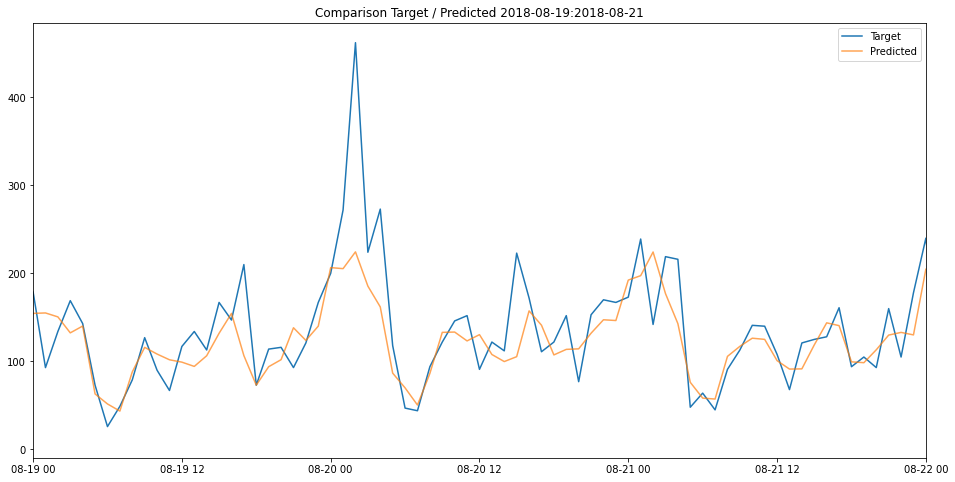

In [48]:
figure, ax = plt.subplots(figsize=(16, 8))
ax.plot(target_test.index, target_test)
ax.plot(target_test.index, predicted_test, alpha=0.7)
ax.set_xlim((datetime.date(2018, 8, 19), datetime.date(2018, 8, 22)))
ax.legend(('Target', 'Predicted'))
ax.set_title('Comparison Target / Predicted 2018-08-19:2018-08-21')

## Общий вывод

Мы обучили несколько моделей, подобрали почти для каждой модели оптимальные параметры для создания признаков, нашли лучшую модель и выполнили предсказание на тестовой выборке. Пускай наша модель не идеально точная, но по графику видно, что она достаточно хорошо предсказывает тенденции на повышение или повышение спроса.